timestamp    float64
TP9          float64
AF7          float64
AF8          float64
TP10         float64
dtype: object


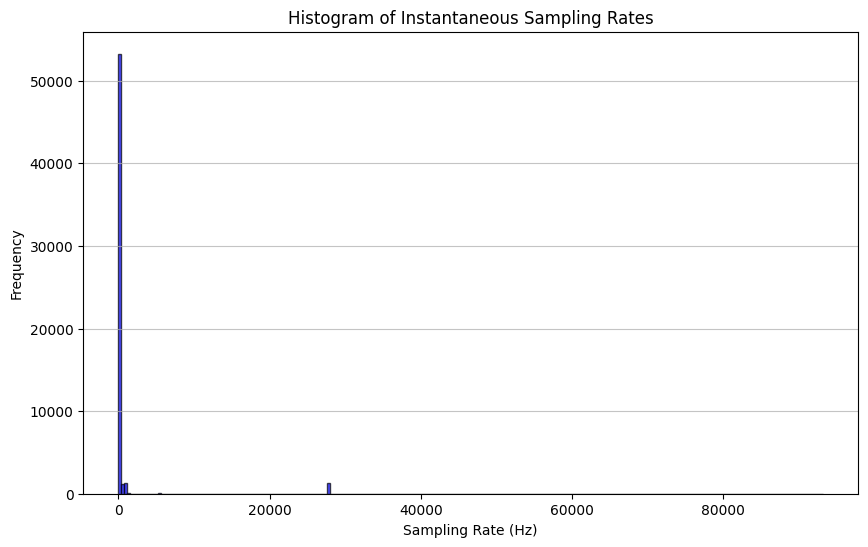

Number of unique timestamps: 57308
Summary statistics for delta t (seconds):
count    57307.000000
mean         0.092840
std          0.145751
min          0.000011
25%          0.028183
50%          0.072964
75%          0.163036
max         26.291183
dtype: float64
Summary statistics for sampling rate (Hz):
count    57307.000000
mean       718.351743
std       4225.498651
min          0.038036
25%          6.133620
50%         13.705353
75%         35.483004
max      93206.755556
dtype: float64
Results saved to eeg_analysis_summary.csv


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
i = 0
# Load CSV file
file_path = "data/kevin/eeg_data.csv"
df = pd.read_csv(file_path)

# Group by unique timestamps
grouped = df.groupby("timestamp")

# Analyze repeated instances
summary = grouped.size().reset_index(name="count")  # Number of repeats per unique timestamp
summary["min"] = grouped["timestamp"].min()
summary["max"] = grouped["timestamp"].max()
summary["range"] = summary["max"] - summary["min"]

# Time-series analysis
unique_timestamps = summary["timestamp"].sort_values().to_numpy()

# Calculate delta times between consecutive timestamps
delta_t = unique_timestamps[1:] - unique_timestamps[:-1]

# Instantaneous sampling rates (in Hz)
sampling_rates = 1.0 / delta_t

# Save results to CSV
summary["delta_t"] = [None] + list(delta_t)  # Add NaN for the first timestamp (no delta)
summary["sampling_rate"] = [None] + list(sampling_rates)  # Add NaN for the first timestamp
output_path = f"eeg_analysis_summary_{i}.csv"
summary.to_csv(output_path, index=False)

# Compute statistics
delta_t_stats = pd.Series(delta_t).describe()
delta_t_median = np.median(delta_t)
delta_t_mode = pd.Series(delta_t).mode().iloc[0]

sampling_rate_stats = pd.Series(sampling_rates).describe()
sampling_rate_median = np.median(sampling_rates)
sampling_rate_mode = pd.Series(sampling_rates).mode().iloc[0]

# Create PDF report
pdf_path = "eeg_analysis_report.pdf"
with PdfPages(pdf_path) as pdf:
    # Histogram of sampling rates
    plt.figure(figsize=(10, 6))
    bins = 250  # Number of bins for the histogram
    plt.hist(sampling_rates, bins=bins, color="blue", edgecolor="black", alpha=0.7)
    plt.title("Histogram of Instantaneous Sampling Rates")
    plt.xlabel("Sampling Rate (Hz)")
    plt.ylabel("Frequency")
    plt.grid(axis="y", alpha=0.75)
    pdf.savefig()  # Save histogram to PDF
    plt.close()

    # Statistics page
    plt.figure(figsize=(8.5, 11))  # Standard letter-size page
    plt.axis('off')  # Turn off axes

    # Create text summary
    stats_text = (
        f"Number of unique timestamps: {len(unique_timestamps)}\n\n"
        "Summary statistics for delta t (seconds):\n"
        f"{delta_t_stats}\n"
        f"Median: {delta_t_median:.6f}\n"
        f"Mode: {delta_t_mode:.6f}\n\n"
        "Summary statistics for sampling rate (Hz):\n"
        f"{sampling_rate_stats}\n"
        f"Median: {sampling_rate_median:.6f}\n"
        f"Mode: {sampling_rate_mode:.6f}\n\n"
        f"Results saved to: {output_path}"
    )

    plt.text(0.1, 0.8, stats_text, fontsize=10, wrap=True)  # Add text to the page
    pdf.savefig()  # Save stats page to PDF
    plt.close()

print(f"PDF report saved to {pdf_path}")